In [13]:
from importlib import reload
import numpy as np
import os
import random
import pickle
import multiprocessing
import functools
import seaborn
import logging
import typhon
import cmocean
from pylab import cm
from os.path import join
from netCDF4 import Dataset
from tqdm import tqdm_notebook
from scipy.interpolate import interp1d
from scipy.signal import detrend
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import processing_tools as ptools
import analysis_tools as atools
from importlib import reload
from moisture_space import utils, plots
from moisture_space import moisture_space
logging.basicConfig(format='%(levelname)s:%(message)s', level=logging.ERROR)

# Config

In [16]:
models = ['ICON', 'NICAM', 'GEOS', 'IFS', 'MPAS', 'FV3', 'UM', 'SAM', 'ARPEGE', 'ERA5']
runs = {
    'ICON': ['2.5km'],
    'NICAM': ['3.5km'],
    'SAM': ['4.0km'],
    'UM': ['5.0km'],
    'FV3': ['3.25km'],
    'GEOS': ['3.0km'],
    'IFS': ['4.0km', '9.0km'],
    'MPAS': ['3.75km'],
    'ARPEGE': ['2.5km'],
    'ERA5': ['31.0km']
}
exps = []
for m in models:
    for run in runs[m]:
        exps.append(m+'-'+run)
        
time_period = ['0810', '0908']
variables_3D = ['TEMP', 'PRES', 'QV', 'QI', 'QC', 'RH', 'ICQI', 'CFI', 'ICQC', 'CFL', 'W']
variables_2D = ['IWV']
datapath = '/mnt/lustre02/work/mh1126/m300773/DYAMOND/{}/random_samples/'
ocean_basins = ['Pacific', 'Atlantic', 'Indic']
sample_days = ['all']
scenarios = sample_days+ocean_basins
filenames = '{}-{}_{}_sample_{}_{}-{}{}.nc'
num_profiles = int(1 * 1e7)
perc_values = np.arange(1, 100.5, 1.0)
reduced_percs_50 = np.arange(1.5, 100.5, 2)
reduced_percs_25 = np.arange(2.5, 100.5, 4)
num_percs = len(perc_values)
iwv_bin_bnds = np.arange(0, 101, 1)
bins = np.arange(0.5, 100.5, 1)
exp = 0
h = np.arange(10, 17600, 100) # height vector to interpolate all models on
num_levels = len(h)
height = {}
for m in models:
    for run in runs[m]:
        key = m+'-'+run
        filename = filenames.format(m, run, variables_3D[0], num_profiles, time_period[0], time_period[1], '')
        if run == '2.5km_winter':
            filename = filenames.format(m, run, variables_3D[0], num_profiles, '0120', '0202')
        if m == 'ERA5':
            filename = f'/mnt/lustre02/work/mh1126/m300773/DYAMOND/ERA5/2016/random_samples/{filename}'
        else:
            filename = join(datapath.format(m), filename)
        #xarr = xr.open_dataset(filename)
        with(Dataset(filename)) as ds:
            height[key] = ds.variables['height'][:].filled(np.nan)
plt.style.use(typhon.plots.styles.get('typhon'))
        

# Read data

In [17]:
reload(moisture_space)
perc = {}
binned = {}
ms_perc = {}
ms_bins = {}
percentiles = {}
for m in models:
    for run in runs[m]:
        exp = m+'-'+run
        if m == 'ERA5':
            p = f'{m}/2016'
        else:
            p = m
        print(exp)
        ms_perc[exp] = {}
        ms_bins[exp] = {}
        
        path_perc = f'{m}-{run}_{time_period[0]}-{time_period[1]}_perc_means_basins_{num_profiles}_0exp.pkl'
        path_bin = f'{m}-{run}_{time_period[0]}-{time_period[1]}_bin_means_basins_{num_profiles}_0exp.pkl'
        
        with open(join(datapath.format(p), path_perc), 'rb' ) as infile:
            perc = pickle.load(infile)
        with open(join(datapath.format(p), path_bin), 'rb' ) as infile:
            binned = pickle.load(infile)       
                    
        for scenario in sample_days:
            if scenario == 'all':
                path_perc = f'{m}-{run}_{time_period[0]}-{time_period[1]}_perc_means_{num_profiles}_1exp.pkl'
                path_bin = f'{m}-{run}_{time_period[0]}-{time_period[1]}_bin_means_{num_profiles}_1exp.pkl'
            else:
                path_perc = f'{m}-{run}_{time_period[0]}-{time_period[1]}_perc_means_{num_profiles}_{scenario}_1exp.pkl'
                path_bin = f'{m}-{run}_{time_period[0]}-{time_period[1]}_bin_means_{num_profiles}_{scenario}_1exp.pkl'
            
            with open(join(datapath.format(p), path_perc), 'rb' ) as infile:
                perc[scenario] = pickle.load(infile)
            with open(join(datapath.format(p), path_bin), 'rb' ) as infile:
                binned[scenario] = pickle.load(infile)
                
        for scenario in sample_days + ocean_basins:
            ms_perc[exp][scenario] = {}
            ms_bins[exp][scenario] = {}
            for var in variables_3D:
                stats_perc = moisture_space.ProfileStats.from_dict(perc[scenario], var)
                ms_perc[exp][scenario][var] = moisture_space.PercMoistureSpace(exp, stats_perc, perc_values, height[exp]).interpolate(h)
                stats_bin = moisture_space.ProfileStats.from_dict(binned[scenario], var)
                ms_bins[exp][scenario][var] = moisture_space.BinMoistureSpace(exp, stats_bin, bins, height[exp], binned[scenario]['count']).interpolate(h)
                #ms_bins[exp][scenario][var].remove_empty_bins(number_threshold=300)
            for var in variables_2D:
                stats_perc = moisture_space.ProfileStats.from_dict(perc[scenario], var)
                ms_perc[exp][scenario][var] = moisture_space.PercMoistureSpace(exp, stats_perc, perc_values, None)   
                stats_bin = moisture_space.ProfileStats.from_dict(binned[scenario], var)
                ms_bins[exp][scenario][var] = moisture_space.BinMoistureSpace(exp, stats_bin, bins, None, binned[scenario]['count'])
                #ms_bins[exp][scenario][var].remove_empty_bins(number_threshold=300)
            if 'OLR' in variables_2D and 'STOA' in variables_2D:
                if m == 'ICON':
                    ms_perc[exp][scenario]['OLR'].profile_stats.mean *= -1 
                    ms_bins[exp][scenario]['OLR'].profile_stats.mean *= -1
                if np.mean(ms_perc[exp][scenario]['STOA'].profile_stats.mean) < 0:
                    ms_perc[exp][scenario]['STOA'].profile_stats.mean *= -1
                    ms_bins[exp][scenario]['STOA'].profile_stats.mean *= -1
        

ms_perc_series = {}
for b in scenarios:
    ms_perc_series[b] = {}
    for var in variables_3D:
        perc_space_list = [ms_perc[exp][b][var] for exp in exps]
        ms_perc_series[b][var] = moisture_space.MoistureSpaceSeries(perc_space_list)

ICON-2.5km
NICAM-3.5km
GEOS-3.0km
IFS-4.0km
IFS-9.0km
MPAS-3.75km
FV3-3.25km
UM-5.0km
SAM-4.0km
ARPEGE-2.5km
ERA5-31.0km


# Fit double Gaussian distribution

In [18]:
def gauss(x, mu, sigma, A):
    return A * np.exp(-(x - mu)**2 / 2 / sigma**2)

def double_gauss(x, mu1, sigma1, A1, mu2, sigma2, A2):
    return gauss(x, mu1, sigma1, A1) + gauss(x, mu2, sigma2, A2)

fit_params = {}
expected ={
    'ICON-2.5km': (20, 30, 0.02, 60, 10, 0.02),
    'NICAM-3.5km': (20, 30, 0.02, 65, 10, 0.02),
    'GEOS-3.0km': (15, 30, 0.02, 50, 10, 0.03),
    'IFS-4.0km': (10, 30, 0.02, 50, 10, 0.03),
    'IFS-9.0km': (20, 30, 0.02, 50, 10, 0.03),
    'MPAS-3.75km': (20, 30, 0.02, 50, 10, 0.03),
    'FV3-3.25km': (20, 30, 0.02, 50, 10, 0.03), 
    'UM-5.0km': (20, 30, 0.02, 50, 10, 0.03),
    'SAM-4.0km': (20, 30, 0.02, 55, 10, 0.03),
    'ARPEGE-2.5km': (20, 30, 0.02, 50, 10, 0.03),
    'ERA5-31.0km': (20, 30, 0.02, 50, 10, 0.03)
}
#b = 'all'

for exp in exps:
    fit_params[exp] = {}
    for b in scenarios:
        iwv_pdf = ms_bins[exp][b]['IWV'].profile_pdf / np.sum(ms_bins[exp][b]['IWV'].profile_pdf)
        x = ms_bins[exp][b]['IWV'].bins
        fit_params[exp][b], cov = curve_fit(double_gauss, x, iwv_pdf, expected[exp])
        

# Saturated IWV:

In [19]:
reload(utils)
bnds_low = [0, 2100]
bnds_high = [2000, 20000]
iwv_sat = {}
iwv_sat_low = {}
iwv_sat_high = {}
iwv = {}
iwv_low = {}
iwv_high = {}
crh = {}
crh_high = {}
crh_low = {}
for exp in exps:
    iwv_sat[exp] = {}
    iwv[exp] = {}
    iwv_sat_low[exp] = {}
    iwv_sat_high[exp] = {}
    iwv_low[exp] = {}
    iwv_high[exp] = {}
    crh[exp] = {}
    crh_high[exp] = {}
    crh_low[exp] = {}
    for b in scenarios:
        rh_sat = np.ones((num_percs, num_levels))
        q_sat = utils.rel_hum2spec_hum(rh_sat, ms_perc[exp][b]['TEMP'].mean, ms_perc[exp][b]['PRES'].mean)
        iwv_sat[exp][b] = utils.calc_IWV(q_sat.T, ms_perc[exp][b]['TEMP'].mean.T, ms_perc[exp][b]['PRES'].mean.T, h)
        iwv_sat_low[exp][b] = utils.calc_IWV(q_sat.T, ms_perc[exp][b]['TEMP'].mean.T, ms_perc[exp][b]['PRES'].mean.T,
                                             h, height_start=bnds_low[0], height_end=bnds_low[1])
        iwv_sat_high[exp][b] = utils.calc_IWV(q_sat.T, ms_perc[exp][b]['TEMP'].mean.T, ms_perc[exp][b]['PRES'].mean.T,
                                             h, height_start=bnds_high[0], height_end=bnds_high[1])
        iwv[exp][b] = utils.calc_IWV(ms_perc[exp][b]['QV'].mean.T, ms_perc[exp][b]['TEMP'].mean.T, ms_perc[exp][b]['PRES'].mean.T, h)
        iwv_low[exp][b] = utils.calc_IWV(ms_perc[exp][b]['QV'].mean.T, ms_perc[exp][b]['TEMP'].mean.T, ms_perc[exp][b]['PRES'].mean.T,
                                         h, height_start=bnds_low[0], height_end=bnds_low[1])
        iwv_high[exp][b] = utils.calc_IWV(ms_perc[exp][b]['QV'].mean.T, ms_perc[exp][b]['TEMP'].mean.T, ms_perc[exp][b]['PRES'].mean.T,
                                         h, height_start=bnds_high[0], height_end=bnds_high[1])
        crh[exp][b] = iwv[exp][b] / iwv_sat[exp][b]
        crh_low[exp][b] = iwv_low[exp][b] / iwv_sat_low[exp][b]
        crh_high[exp][b] = iwv_high[exp][b] / iwv_sat_high[exp][b]

DEBUG:findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=14.994.
DEBUG:findfont: score(<Font 'STIXGeneral' (STIXGeneralItalic.ttf) italic normal 400 normal>) = 11.05
DEBUG:findfont: score(<Font 'DejaVu Serif' (DejaVuSerif-Italic.ttf) italic normal 400 normal>) = 11.05
DEBUG:findfont: score(<Font 'cmmi10' (cmmi10.ttf) normal normal 400 normal>) = 10.05
DEBUG:findfont: score(<Font 'STIXGeneral' (STIXGeneralBolIta.ttf) italic normal bold normal>) = 11.335
DEBUG:findfont: score(<Font 'cmtt10' (cmtt10.ttf) normal normal 400 normal>) = 10.05
DEBUG:findfont: score(<Font 'STIXSizeThreeSym' (STIXSizThreeSymReg.ttf) normal normal regular normal>) = 10.05
DEBUG:findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono-Oblique.ttf) oblique normal 400 normal>) = 11.05
DEBUG:findfont: score(<Font 'DejaVu Serif' (DejaVuSerif-BoldItalic.ttf) italic normal bold normal>) = 11.335
DEBUG:findfont: score(<Font 'STIXSizeTwoSym' (STIXSizTwoSymReg.ttf) normal no

DEBUG:findfont: score(<Font 'DejaVu LGC Serif' (DejaVuLGCSerifCondensed-Bold.ttf) normal normal bold condensed>) = 10.535
DEBUG:findfont: score(<Font 'Liberation Serif' (LiberationSerif-Italic.ttf) italic normal 400 normal>) = 11.05
DEBUG:findfont: score(<Font 'Liberation Mono' (LiberationMono-Regular.ttf) normal normal 400 normal>) = 10.05
DEBUG:findfont: score(<Font 'DejaVu LGC Serif' (DejaVuLGCSerif-Italic.ttf) italic normal 400 normal>) = 11.05
DEBUG:findfont: score(<Font 'Liberation Sans' (LiberationSans-Italic.ttf) italic normal 400 normal>) = 11.05
DEBUG:findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=14.994 to DejaVu Sans ('/sw/rhel6-x64/conda/anaconda3-bleeding_edge/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000.


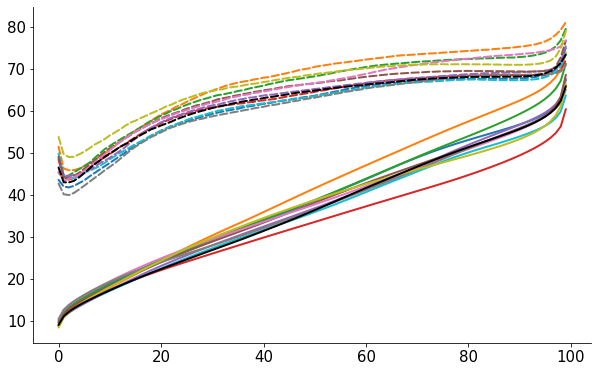

DEBUG:findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=18.0.
DEBUG:findfont: score(<Font 'STIXGeneral' (STIXGeneralItalic.ttf) italic normal 400 normal>) = 11.05
DEBUG:findfont: score(<Font 'DejaVu Serif' (DejaVuSerif-Italic.ttf) italic normal 400 normal>) = 11.05
DEBUG:findfont: score(<Font 'cmmi10' (cmmi10.ttf) normal normal 400 normal>) = 10.05
DEBUG:findfont: score(<Font 'STIXGeneral' (STIXGeneralBolIta.ttf) italic normal bold normal>) = 11.335
DEBUG:findfont: score(<Font 'cmtt10' (cmtt10.ttf) normal normal 400 normal>) = 10.05
DEBUG:findfont: score(<Font 'STIXSizeThreeSym' (STIXSizThreeSymReg.ttf) normal normal regular normal>) = 10.05
DEBUG:findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono-Oblique.ttf) oblique normal 400 normal>) = 11.05
DEBUG:findfont: score(<Font 'DejaVu Serif' (DejaVuSerif-BoldItalic.ttf) italic normal bold normal>) = 11.335
DEBUG:findfont: score(<Font 'STIXSizeTwoSym' (STIXSizTwoSymReg.ttf) normal norm

DEBUG:findfont: score(<Font 'DejaVu LGC Serif' (DejaVuLGCSerifCondensed-Bold.ttf) normal normal bold condensed>) = 10.535
DEBUG:findfont: score(<Font 'Liberation Serif' (LiberationSerif-Italic.ttf) italic normal 400 normal>) = 11.05
DEBUG:findfont: score(<Font 'Liberation Mono' (LiberationMono-Regular.ttf) normal normal 400 normal>) = 10.05
DEBUG:findfont: score(<Font 'DejaVu LGC Serif' (DejaVuLGCSerif-Italic.ttf) italic normal 400 normal>) = 11.05
DEBUG:findfont: score(<Font 'Liberation Sans' (LiberationSans-Italic.ttf) italic normal 400 normal>) = 11.05
DEBUG:findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=18.0 to DejaVu Sans ('/sw/rhel6-x64/conda/anaconda3-bleeding_edge/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000.


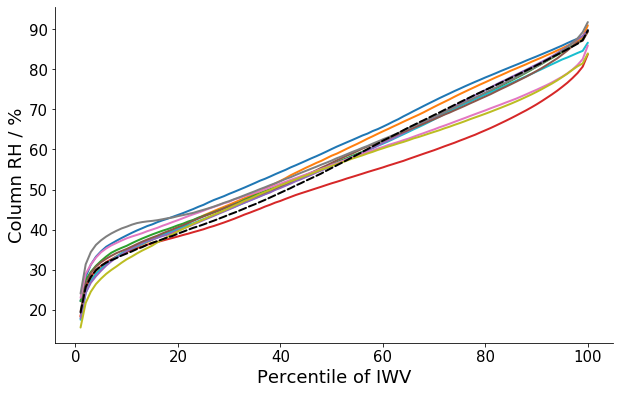

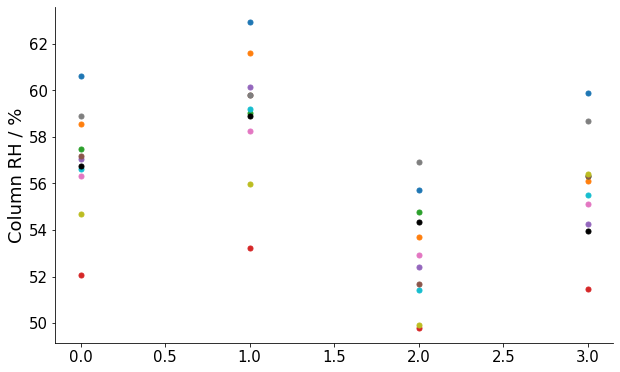

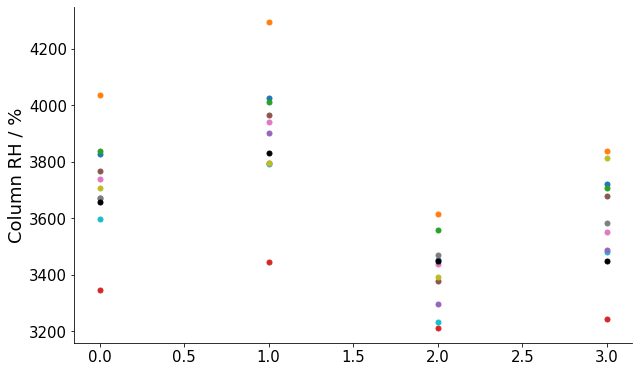

In [8]:
fig, ax = plt.subplots()
b = 'all'
for exp in exps:
    ax.plot(iwv_sat[exp][b], '--', color=plots.DYAMOND_colors(exp))
    ax.plot(iwv[exp][b], '-', color=plots.DYAMOND_colors(exp))
    #ax.plot(ms_perc[exp][b]['IWV'].mean, '-', color=plots.DYAMOND_colors(exp))

fig, ax = plt.subplots()
for exp in exps:
    ax.plot(perc_values, crh[exp][b] * 1e2, color=plots.DYAMOND_colors(exp))
    ax.set_xlabel('Percentile of IWV')
    ax.set_ylabel('Column RH / %')    

fig, ax = plt.subplots()
for exp in exps:
    for i, s in enumerate(scenarios):
        ax.plot(i, np.mean(crh[exp][s] * 1e2), '.', color=plots.DYAMOND_colors(exp))
        ax.set_xlabel('')
        ax.set_ylabel('Column RH / %')
        
fig, ax = plt.subplots()
for exp in exps:
    for i, s in enumerate(scenarios):
        ax.plot(i, np.mean(ms_perc[exp][s]['IWV'].mean * 1e2), '.', color=plots.DYAMOND_colors(exp))
        ax.set_xlabel('')
        ax.set_ylabel('Column RH / %')



0.6060467209060003
0.5856953689245905
0.5746927057649502
0.5205738576335146
0.566093319731459
0.5705785217471209
0.5716678103728596
0.5631226959223633
0.5889741653787555
0.5468130709909355
0.5674690231915553


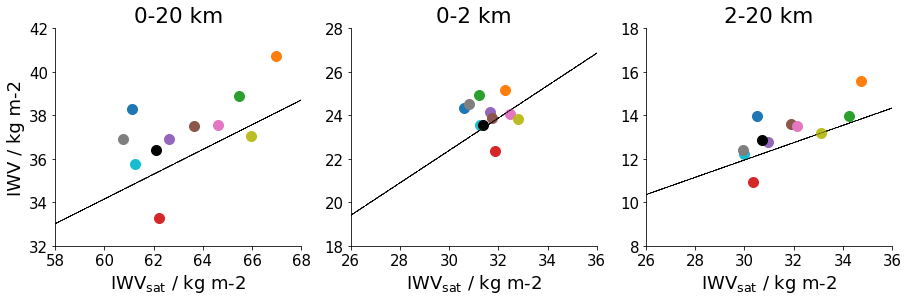

In [730]:
crh_mean = 0
crh_low_mean = 0
crh_high_mean = 0
for exp in exps:
    print(np.mean(crh[exp][b]))
    crh_mean += crh[exp][b]
    crh_low_mean += crh_low[exp][b]
    crh_high_mean += crh_high[exp][b]

crh_mean = np.mean(crh_mean) / len(exps)
crh_low_mean = np.mean(crh_low_mean) / len(exps)
crh_high_mean = np.mean(crh_high_mean) / len(exps)
    
fig, ax = plt.subplots(1, 3, sharey=False, figsize=(15, 4))
for exp in exps:
    ax[0].plot(np.mean(iwv_sat[exp]['all']), np.mean(iwv[exp]['all']), 'o', color=plots.DYAMOND_colors(exp))
    ax[0].plot(np.arange(0, 80), np.arange(0, 80) * crh_mean, '--', color='k', lw=0.5)
    #ax[0].plot(np.mean(iwv_sat_low[exp]['all'] + iwv_sat_high[exp]['all']), np.mean(iwv_low[exp]['all'] + iwv_high[exp]['all']), 'x', color=plots.DYAMOND_colors(exp))
    ax[0].set_xlabel('IWV$_\mathrm{sat}$ / kg m-2')
    ax[0].set_ylabel('IWV / kg m-2')
    ax[0].set_ylim(32, 42)
    ax[0].set_xlim(58, 68)
    ax[0].set_title('0-20 km')
    ax[1].plot(np.arange(0, 80), np.arange(0, 80) * crh_low_mean, '--', color='k', lw=0.5)
    ax[2].plot(np.arange(0, 80), np.arange(0, 80) * crh_high_mean, '--', color='k', lw=0.5)
    ax[1].plot(np.mean(iwv_sat_low[exp]['all']), np.mean(iwv_low[exp]['all']), 'o', color=plots.DYAMOND_colors(exp))
    ax[2].plot(np.mean(iwv_sat_high[exp]['all']), np.mean(iwv_high[exp]['all']), 'o', color=plots.DYAMOND_colors(exp))
    
    ax[1].set_ylim(18, 28)
    ax[1].set_xlim(26, 36)
    ax[1].set_xlabel('IWV$_\mathrm{sat}$ / kg m-2')
    ax[1].set_title('0-2 km')
    ax[2].set_ylim(8, 18)
    ax[2].set_xlim(26, 36)
    ax[2].set_xlabel('IWV$_\mathrm{sat}$ / kg m-2')
    ax[2].set_title('2-20 km')

# Plot IWV distribution

In [735]:
fit_params[exp]

KeyError: 'ERA5-31.0km'

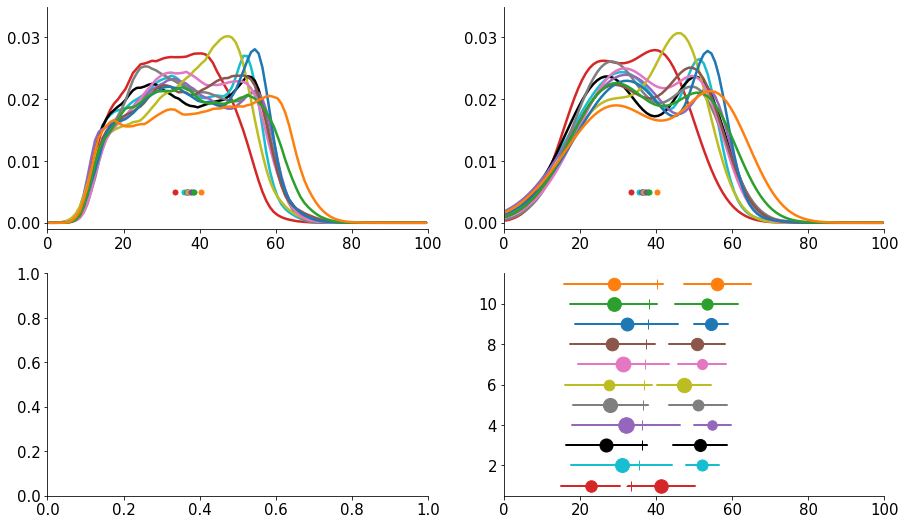

In [20]:
fig, ax = plt.subplots(2, 2, figsize=(15, 9))
b = 'all'
exps_sorted = sorted(exps, key=lambda e: np.mean(ms_perc[e][b]['IWV'].mean))
for i, exp in enumerate(exps_sorted):
    iwv_pdf = ms_bins[exp][b]['IWV'].profile_pdf / np.sum(ms_bins[exp][b]['IWV'].profile_pdf)
    mean_iwv_fitted = np.average(ms_bins[exp][b]['IWV'].bins, weights=double_gauss(ms_bins[exp][b]['IWV'].bins, *fit_params[exp][b]))
    mean_iwv = np.average(ms_bins[exp][b]['IWV'].bins, weights=iwv_pdf)
    ax[0, 0].plot(ms_bins[exp][b]['IWV'].bins, iwv_pdf, '-', color=plots.DYAMOND_colors(exp), lw=2.5)
    ax[0, 0].plot(mean_iwv, 0.005, '.', color=plots.DYAMOND_colors(exp))
    #ax[0, 0].plot([iwv_sat[exp][b][-1], iwv_sat[exp][b][-1]], [0., 0.035], '-', lw=2, color=plots.DYAMOND_colors(exp), alpha=0.5)
    
    ax[0, 1].plot(ms_bins[exp][b]['IWV'].bins, double_gauss(ms_bins[exp][b]['IWV'].bins, *fit_params[exp][b]), color=plots.DYAMOND_colors(exp), lw=2.5, ls='-')
    ax[0, 1].plot(mean_iwv_fitted, 0.005, '.', color=plots.DYAMOND_colors(exp))
    ax[0, 0].set_ylim(-0.001, 0.035)
    ax[0, 1].set_ylim(-0.001, 0.035)
    ax[0, 0].set_xlim(-0.001, 100)
    ax[0, 1].set_xlim(-0.001, 100)
    mean_1 = fit_params[exp][b][0]
    mean_2 = fit_params[exp][b][3]
    std_1 = fit_params[exp][b][1]
    std_2 = fit_params[exp][b][4]
    A_1 = fit_params[exp][b][2]
    A_2 = fit_params[exp][b][5]
    p = A_1 / (A_1 + A_2)
    q = 1 - p
    ax[1, 1].plot(mean_1, 1 + i, '.', color=plots.DYAMOND_colors(exp), markersize=p * 50)
    ax[1, 1].plot(mean_2, 1 + i, '.', color=plots.DYAMOND_colors(exp), markersize=q * 50)
    ax[1, 1].plot(mean_iwv_fitted, 1 + i, '+', color=plots.DYAMOND_colors(exp))
#    ax[1, 1].plot(p * mean_1 / std_1 + q * mean_2 / std_2, 1 + i, 'x', color=plots.DYAMOND_colors(exp))
#     w = A_1 / (A_1 + A_2)
#     ax[1, 1].plot(mean_1 * w + mean_2 * (1 - w), 1 + i, '.', color=plots.DYAMOND_colors(exp))
    ax[1, 1].plot([mean_1 - std_1, mean_1], [1 + i, 1 + i], color=plots.DYAMOND_colors(exp), ls='-')
    ax[1, 1].plot([mean_1, mean_1 + std_1], [1 + i, 1 + i], color=plots.DYAMOND_colors(exp), ls='-')
    ax[1, 1].plot([mean_2 - std_2, mean_2], [1 + i, 1 + i], color=plots.DYAMOND_colors(exp), ls='-')
    ax[1, 1].plot([mean_2, mean_2 + std_2], [1 + i, 1 + i], color=plots.DYAMOND_colors(exp), ls='-')
    ax[1, 1].set_xlim(0, 100)
    #ax[1].plot()
    #ax[1].plot()

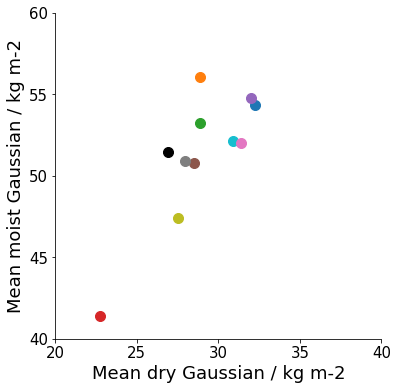

In [741]:
fig, ax = plt.subplots(figsize=(6, 6))
b = 'all'
means_1 = np.array([fit_params[exp][b][0] for exp in exps])
means_2 = np.array([fit_params[exp][b][3] for exp in exps])
A_1 = np.array([fit_params[exp][b][2] for exp in exps])
A_2 = np.array([fit_params[exp][b][5] for exp in exps])
for i, exp in enumerate(exps):
    p = A_1[i] / (A_1[i] + A_2[i])
    ax.plot(means_1[i], means_2[i], 'o', color=plots.DYAMOND_colors(exp))
ax.set_xlabel('Mean dry Gaussian / kg m-2')
ax.set_ylabel('Mean moist Gaussian / kg m-2')
ax.set_yticks(np.arange(40, 61, 5))
ax.set_ylim(40, 60)
ax.set_xlim(20, 40)
ax.set_aspect('equal')


# Compare IWV with hypothetical IWV from constant RH

282.5904109937643


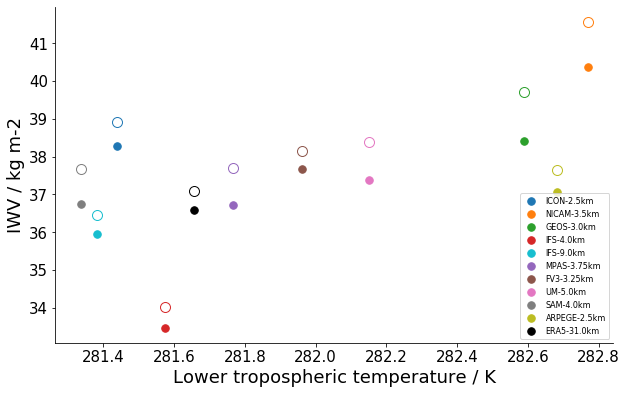

In [742]:
fig, ax = plt.subplots()
b = 'all'
q_rh_const = np.zeros((len(exps), num_percs, len(h)))
iwv_rh_const = np.zeros((len(exps), num_percs))
for i, exp in enumerate(exps):
    q_rh_const[i] = utils.rel_hum2spec_hum(ms_perc[exp][b]['RH'].mean, ms_perc[exp][b]['TEMP'].mean, ms_perc[exp][b]['PRES'].mean)
    iwv_rh_const[i] = utils.calc_IWV(q_rh_const[i].T, ms_perc[exp][b]['TEMP'].mean.T, ms_perc[exp][b]['PRES'].mean.T, h)
    if exp == 'GEOS-3.0km':
        print(ms_perc[exp][b]['TEMP'].area_mean(lower_bnd=0, upper_bnd=6000))
    ax.plot(ms_perc[exp][b]['TEMP'].area_mean(lower_bnd=0, upper_bnd=6000), ms_perc[exp][b]['IWV'].mean_profile(), '.', color=plots.DYAMOND_colors(exp), markersize=15, label=exp)
    ax.plot(ms_perc[exp][b]['TEMP'].area_mean(lower_bnd=0, upper_bnd=6000), np.mean(iwv_rh_const[i]), 'o', markersize=10, color=plots.DYAMOND_colors(exp), mfc='none')
    #ax.plot(ms_perc[exp][b]['IWV'].mean_profile(), ms_perc[exp][b]['OLR'].mean_profile(), '.', color=plots.DYAMOND_colors(exp))
    
ax.set_xlabel('Lower tropospheric temperature / K')
ax.set_ylabel('IWV / kg m-2')
ax.legend(fontsize=8)

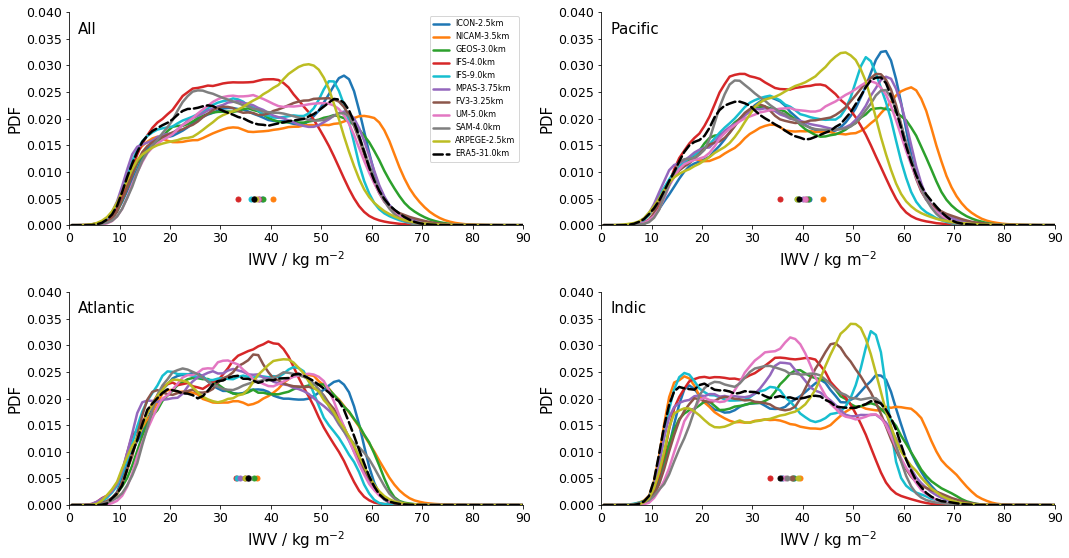

In [743]:
scenarios = ['all']+ocean_basins
num_cols = 2
num_rows = int(np.ceil(len(scenarios) / num_cols))

plt.rcParams.update({'font.size': 15})
fig, ax = plt.subplots(num_rows, num_cols, figsize=(7.5 * num_cols, 4 * num_rows))

ax = ax.ravel()
for i, basin in enumerate(scenarios):
    for exp in exps:
        iwv_pdf = ms_bins[exp][basin]['IWV'].profile_pdf
        mean_iwv = np.average(ms_bins[exp][b]['IWV'].bins, weights=iwv_pdf)
        ax[i].plot(ms_bins[exp][basin]['IWV'].bins, iwv_pdf / np.sum(iwv_pdf), color=plots.DYAMOND_colors(exp), lw=2.5, label=exp)
        #ax[i].plot(ms_bins[exp][basin]['IWV'].bins, double_gauss(ms_bins[exp][basin]['IWV'].bins, *fit_params[exp][basin]), '--', color=plots.DYAMOND_colors(exp))
        
        ax[i].plot(mean_iwv, 0.005, '.', color=plots.DYAMOND_colors(exp))
        #ax[i].plot(fit_params[exp][basin][0], 0, '.', lw=2, color=plots.DYAMOND_colors(exp))
        #ax[i].plot(fit_params[exp][basin][3], 0, 'x', lw=2, color=plots.DYAMOND_colors(exp))
        ax[i].set_xlim(0, 90)
        ax[i].set_ylim(0, 0.04)
        ax[i].set_xlabel('IWV / kg m$^{-2}$')
        ax[i].set_ylabel('PDF')
#ax[i+1].set_visible(False)
typhon.plots.label_axes(labels=map(lambda s: s.title(), scenarios))
plt.tight_layout()
ax[0].legend(fontsize=8)

# Connection to strength of convection?

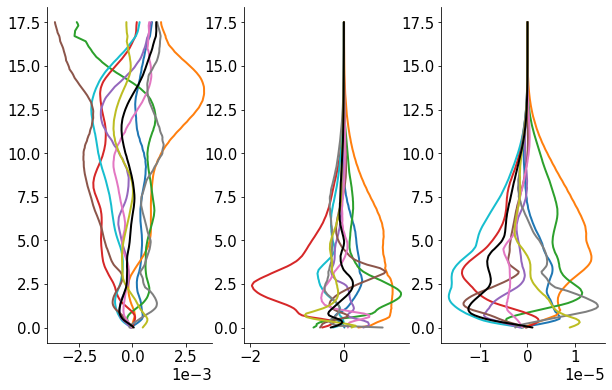

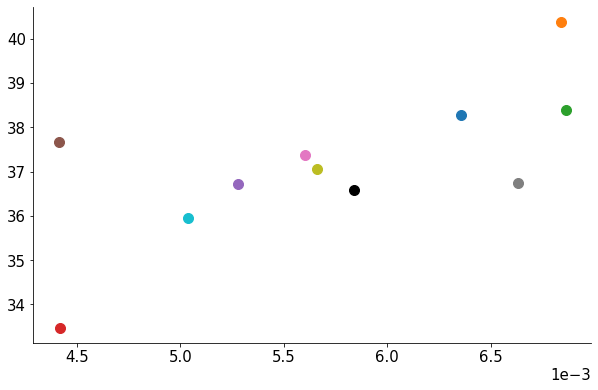

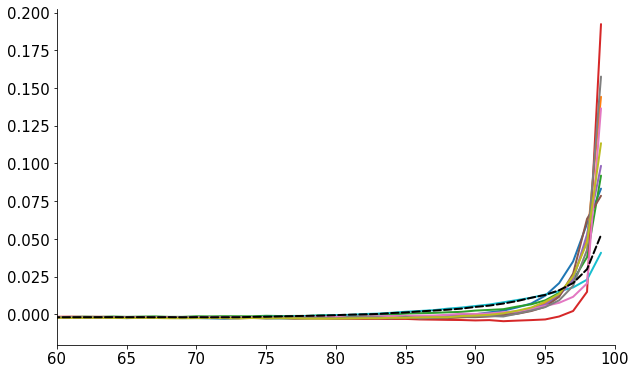

In [11]:
b = 'all'
for exp in exps:
    density = utils.calc_density_moist_air(
        ms_perc[exp][b]['PRES'].mean,
        ms_perc[exp][b]['TEMP'].mean,
        ms_perc[exp][b]['QV'].mean
    )
    q_transport = ms_perc[exp][b]['QV'].mean * ms_perc[exp][b]['W'].mean
    profile_stats = moisture_space.ProfileStats('RHO', density)
    ms_perc[exp][b]['RHO'] = moisture_space.PercMoistureSpace(exp, profile_stats, perc_values, h)
    profile_stats = moisture_space.ProfileStats('QV_Transport', q_transport)
    ms_perc[exp][b]['QV_transport'] = moisture_space.PercMoistureSpace(exp, profile_stats, perc_values, h)

for var in ['RHO', 'QV_transport']:
    perc_space_list = [ms_perc[exp][b][var] for exp in exps]
    ms_perc_series[b][var] = moisture_space.MoistureSpaceSeries(perc_space_list)

pstart = 60
pend = 100
fig, ax = plt.subplots(1, 3)
for exp in exps:
    ax[0].plot(ms_perc[exp][b]['W'].mean_profile(pstart, pend) - np.mean(ms_perc_series[b]['W'].mean[pstart:pend+1], axis=0), h * 1e-3, '-', color=plots.DYAMOND_colors(exp))
    #ax[0].plot(np.gradient(np.mean(ms_perc[exp][b]['W'].mean[pstart:pend] * ms_perc[exp][b]['RHO'].mean[pstart:pend], axis=0), h), h * 1e-3, '-', color=plots.DYAMOND_colors(exp))
    ax[2].plot(ms_perc[exp][b]['QV_transport'].mean_profile(pstart, pend) - np.mean(ms_perc_series[b]['QV_transport'].mean[pstart:pend], axis=0), h * 1e-3, '-', color=plots.DYAMOND_colors(exp))
    ax[1].plot((ms_perc[exp][b]['QV'].mean_profile(pstart, pend) - np.mean(ms_perc_series[b]['QV'].mean[pstart:pend], axis=0)) * 1e3, h * 1e-3, '-', color=plots.DYAMOND_colors(exp))
    
fig, ax = plt.subplots()
fig2, ax2 = plt.subplots()
for exp in exps:
    ind_500_hPa = np.argmin(np.abs(ms_perc[exp][b]['PRES'].mean_profile(pstart, pend) - 50000))
    transport_500hPa = ms_perc[exp][b]['QV_transport'].mean[:, ind_500_hPa]
    w_500hPa = ms_perc[exp][b]['W'].mean[:, ind_500_hPa]
    density_500hPa = ms_perc[exp][b]['RHO'].mean[:, ind_500_hPa]
    ax.plot(np.mean(w_500hPa[pstart:pend]), ms_perc[exp][b]['IWV'].mean_profile(), 'o', color=plots.DYAMOND_colors(exp))
    ax2.plot(w_500hPa * density_500hPa, color=plots.DYAMOND_colors(exp))
    ax2.set_xlim(60, 100)
    #ax2.set_ylim(-0.01, 0.01)

In [639]:
ms_perc[exp]

{'all': {'TEMP': <moisture_space.moisture_space.PercMoistureSpace at 0x2acdec1bcba8>,
  'PRES': <moisture_space.moisture_space.PercMoistureSpace at 0x2acdec1bc908>,
  'QV': <moisture_space.moisture_space.PercMoistureSpace at 0x2acdec1bc470>,
  'QI': <moisture_space.moisture_space.PercMoistureSpace at 0x2acdec1bcb38>,
  'QC': <moisture_space.moisture_space.PercMoistureSpace at 0x2acdec1bcdd8>,
  'RH': <moisture_space.moisture_space.PercMoistureSpace at 0x2acdea887780>,
  'ICQI': <moisture_space.moisture_space.PercMoistureSpace at 0x2acdea887978>,
  'CFI': <moisture_space.moisture_space.PercMoistureSpace at 0x2acdea8876d8>,
  'ICQC': <moisture_space.moisture_space.PercMoistureSpace at 0x2acdea8875f8>,
  'CFL': <moisture_space.moisture_space.PercMoistureSpace at 0x2acdea887ef0>,
  'W': <moisture_space.moisture_space.PercMoistureSpace at 0x2acdea887908>,
  'IWV': <moisture_space.moisture_space.PercMoistureSpace at 0x2b51d82b6550>,
  'H_tropo': <moisture_space.moisture_space.PercMoistureSpa

In [645]:
infile = '/mnt/lustre01/scratch/m/m300773/ARPEGE-2.5km_H_0810_03_hinterp.nc'


In [656]:
with Dataset(infile) as ds:
    H = ds.variables['H'][0]


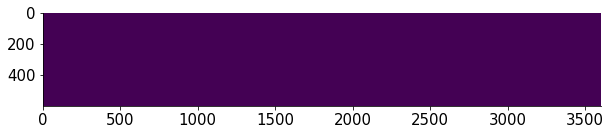

In [664]:
fig, ax = plt.subplots()
ax.imshow(np.flipud(H[-1]))

In [661]:
H[-1]

masked_array(
  data=[[17., 17., 17., ..., 17., 17., 17.],
        [17., 17., 17., ..., 17., 17., 17.],
        [17., 17., 17., ..., 17., 17., 17.],
        ...,
        [17., 17., 17., ..., 17., 17., 17.],
        [17., 17., 17., ..., 17., 17., 17.],
        [17., 17., 17., ..., 17., 17., 17.]],
  mask=False,
  fill_value=1e+20,
  dtype=float32)

In [336]:
iwv_bin_bnds = np.arange(0, 101, 1)
bin_idx = np.digitize(iwv_geos, iwv_bin_bnds)
count = np.asarray([len(np.where(bin_idx == bi)[0]) for bi in bins])

In [362]:
np.average(np.arange(0.5, 100.5, 1), weights=count)

38.0038511

In [338]:
np.mean(iwv_geos)

38.003796

In [346]:
np.mean(ms_perc['GEOS-3.0km'][b]['IWV'].mean)

38.004463

In [312]:
iwv_pdf = ms_bins['GEOS-3.0km'][b]['IWV'].profile_pdf 
mean_iwv = np.average(ms_bins['GEOS-3.0km'][b]['IWV'].bins, weights=iwv_pdf)
mean_iwv

39.50445117121874

In [295]:
np.where(np.isnan(temp_geos[0]))[0].shape

(2554460,)

In [302]:
infilet = '/mnt/lustre02/work/mh1126/m300773/DYAMOND/GEOS/GEOS-3.0km_TEMP_hinterp_merged_0830-0908.nc'
infileh = '/mnt/lustre02/work/mh1126/m300773/DYAMOND/GEOS/GEOS-3.0km_H_hinterp_merged_0830-0908.nc'
infileth = '/mnt/lustre02/work/mh1126/m300773/DYAMOND/GEOS/target_height.nc'

In [353]:
with Dataset(infileh) as ds:
    h_geos = ds.variables['H'][0]
    
with Dataset(infilet) as ds:
    temp = ds.variables['T'][0]

In [354]:
with Dataset(infileth) as ds:
    h_geos = ds.variables['target_height']

In [356]:
h_geos

RuntimeError: NetCDF: Not a valid ID

In [708]:
b = np.array([1,0.99763,0.995003,0.991984,0.9885,0.984542,0.980072,0.975078,0.969513,0.963352,0.95655,0.949064,0.94086,0.931881,0.922096,0.911448,0.8999,0.887408,0.873929,0.859432,0.843881,0.827256,0.809536,0.790717,0.770798,0.749797,0.727739,0.704669,0.680643,0.655736,0.630036,0.603648,0.576692,0.549301,0.521619,0.4938,0.466003,0.438391,0.411125,0.384363,0.358254,0.332939,0.308598,0.285354,0.263242,0.242244,0.222333,0.203491,0.185689,0.16891,0.153125,0.138313,0.124448,0.111505,0.099462,0.088286,0.077958,0.068448,0.059728,0.051773,0.044548,0.038026,0.032176,0.026964,0.022355,0.018318,0.014816,0.011806,0.009261,0.007133,0.005378,0.003971,0.002857,0.001992,0.001353,0.00089,0.000562,0.00034,0.000199,0.000112,0.000059,0.000024,0.000007,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0])

In [709]:
len(b)

113

In [710]:
137 - 113

24

In [714]:
height['IFS-4.0km']

array([3.3763578e+04, 3.2912480e+04, 3.2098084e+04, 3.1317041e+04,
       3.0566631e+04, 2.9844623e+04, 2.9149355e+04, 2.8479756e+04,
       2.7834945e+04, 2.7213865e+04, 2.6615363e+04, 2.6038244e+04,
       2.5481322e+04, 2.4943518e+04, 2.4423752e+04, 2.3921037e+04,
       2.3434533e+04, 2.2963553e+04, 2.2507594e+04, 2.2066121e+04,
       2.1638664e+04, 2.1224893e+04, 2.0824301e+04, 2.0436201e+04,
       2.0059867e+04, 1.9694561e+04, 1.9339475e+04, 1.8993484e+04,
       1.8655609e+04, 1.8324998e+04, 1.8000895e+04, 1.7682631e+04,
       1.7369158e+04, 1.7059545e+04, 1.6752967e+04, 1.6449043e+04,
       1.6147171e+04, 1.5847042e+04, 1.5548083e+04, 1.5249804e+04,
       1.4951860e+04, 1.4653999e+04, 1.4356105e+04, 1.4058115e+04,
       1.3759917e+04, 1.3461469e+04, 1.3162749e+04, 1.2863740e+04,
       1.2564267e+04, 1.2264293e+04, 1.1963788e+04, 1.1662714e+04,
       1.1361067e+04, 1.1058893e+04, 1.0756181e+04, 1.0452898e+04,
       1.0149049e+04, 9.8445967e+03, 9.5395635e+03, 9.2339600e